# CIR Model and cash vs Zero-Coupon Bonds

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline
import risk_toolkit as rk
import pandas as pd
import numpy as np

## Implementing the Cox Ingersoll Ross Model for interest rates

We saw in the previous lab that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

### Quick Explanation of Short Rate vs Annual Rate

The distinction between the instantaneous rate and the annualized rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we'll need to answer a second question, which is how often will that interest be paid?

If it's paid just once at the end of the year, the answer is easy. The dollar grows to 2 dollars (one dollar in principle and another dollar in interest).

In [2]:
1 + 1*1

2

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$

### Implementation of the CIR Model

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [3]:
def cir_model(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_year=12, r_0=None):
    
    '''
    Generates random interest rate evolution over time for the Cox Ingersoll Ross Model (CIR).
    b and r_0 are assumed to be annualized rates and the returned values are annualized rates.
    '''
    
    if r_0 is None: r_0 = b
    
    r_0 = rk.annual_to_inst_rate(r_0)
    
    dt = 1 / steps_year
    
    num_steps = int(n_years * steps_year) + 1
    
    shock = np.random.normal(0, scale = np.sqrt(dt), size=(num_steps, n_scenarios))
    
    rates = np.empty_like(shock)
    
    rates[0] = r_0
     
    for step in range(1, num_steps):
        
        r_t = rates[step - 1]
        
        d_r_t = a * (b - r_t) * dt + sigma * np.sqrt(r_t) * shock[step]
        
        rates[step] = abs(r_t + d_r_t)
        
    rates = pd.DataFrame(data=rk.short_term_rate_to_annual(rates), index=range(num_steps))
    
    return rates

<AxesSubplot:>

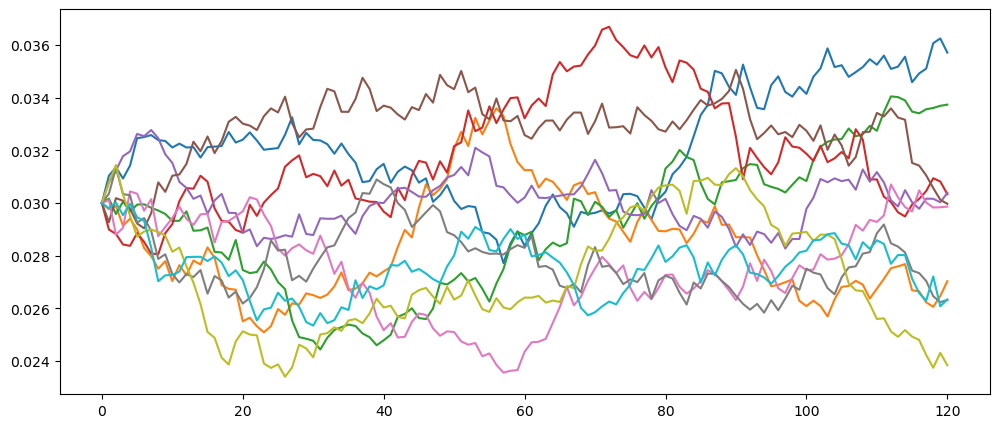

In [4]:
cir_model(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [5]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir_model(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [6]:
def show_cir_model(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    rk.cir_model(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))
    
controls = widgets.interactive(show_cir_model,
                               r_0 = (0, 0.15, 0.01),
                               a = (0, 1, 0.1),
                               b = (0, 0.15, 0.01),
                               sigma = (0, 0.1, 0.01),
                               n_scenarios = (1,100))

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [13]:
a_0 = 0.75 # Starting capital

rates, bond_prices = rk.cir_model(r_0=0.03, b=0.03, n_scenarios=10)

liabilities = bond_prices

zcbond_10y = pd.Series(data=[1], index=[10])

zc_0 = rk.present_value(zcbond_10y, interest_rate=0.03)

n_bonds = a_0 / zc_0

asset_value_zc_bonds = n_bonds * bond_prices

asset_value_cash = a_0 * (rates / 12 + 1).cumprod()

<AxesSubplot:>

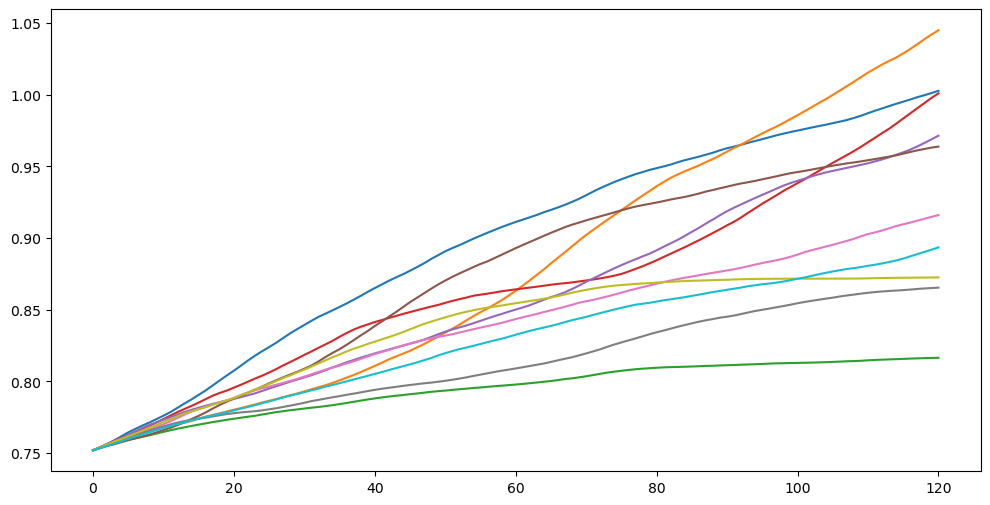

In [14]:
asset_value_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

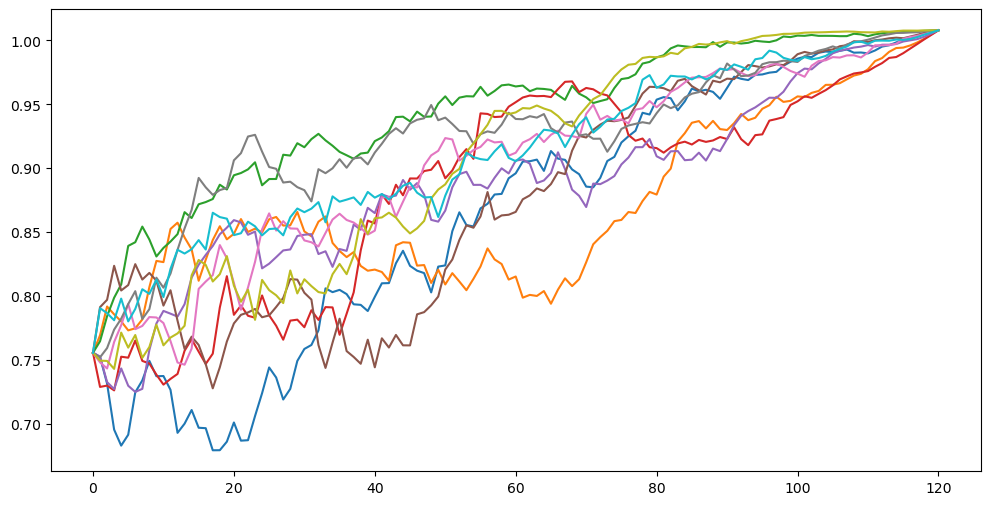

In [15]:
asset_value_zc_bonds.plot(legend=False, figsize=(12, 6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 scenarios)'}>

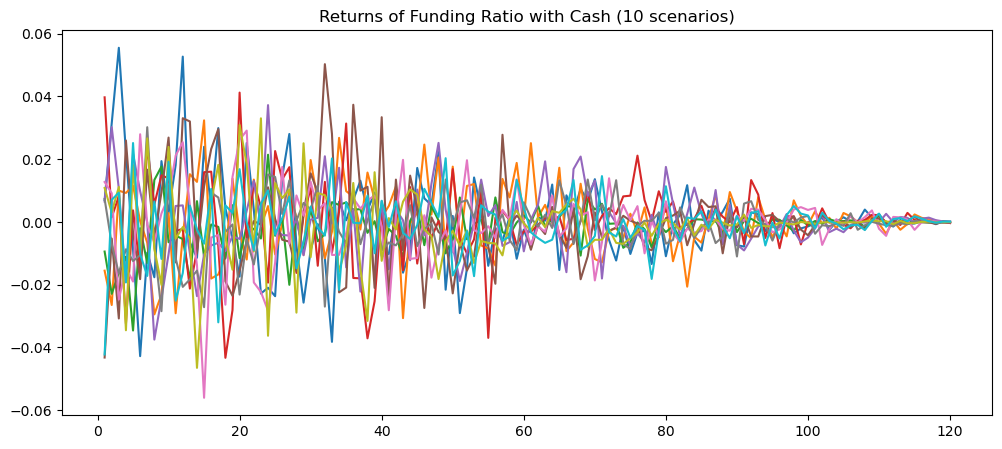

In [16]:
(asset_value_cash / liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', figsize=(12,5), legend=False)

<AxesSubplot:title={'center':'Returns of Funding Ratio with Zero Coupon Bonds (10 scenarios)'}>

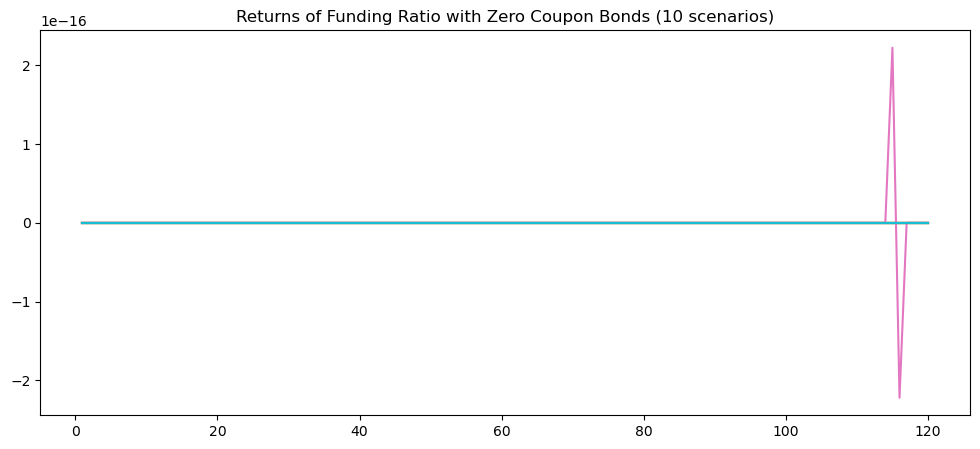

In [18]:
(asset_value_zc_bonds / liabilities).pct_change().plot(title='Returns of Funding Ratio with Zero Coupon Bonds (10 scenarios)', legend=False, figsize=(12,5))

### Terminal funding ratio

In [26]:
a_0 = 0.75

rates, bond_prices = rk.cir_model(n_scenarios=100000, r_0=0.03, b=0.03)

liabilities = bond_prices

zc_0 = rk.present_value(zcbond_10y, 0.03)

n_bonds = a_0 / zc_0

asset_value_bonds = n_bonds * bond_prices

asset_value_cash = a_0 * (rates / 12 + 1).cumprod()

<AxesSubplot:>

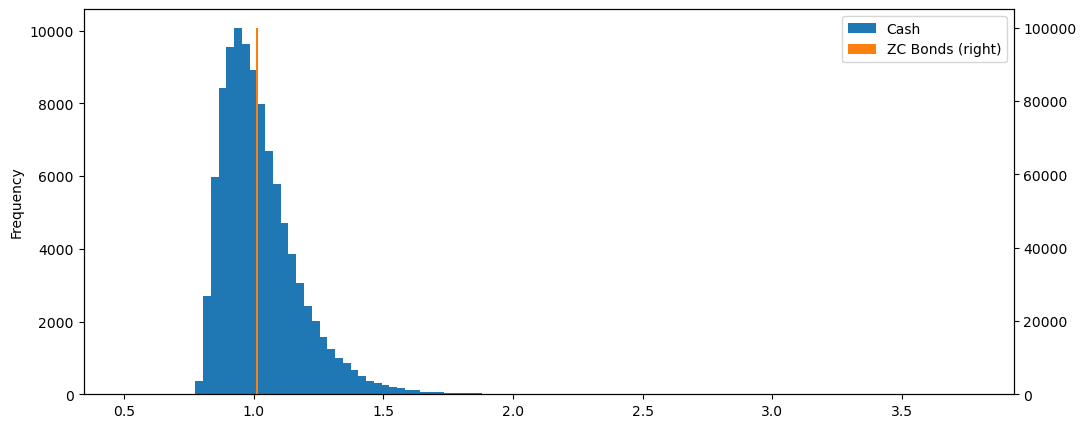

In [27]:
terminal_funding_ratio_cash = asset_value_cash.iloc[-1] / liabilities.iloc[-1]

terminal_funding_ratio_bonds = asset_value_bonds.iloc[-1] / liabilities.iloc[-1]

ax = terminal_funding_ratio_cash.plot.hist(label='Cash', figsize=(12,5), bins=100, legend=True)

terminal_funding_ratio_bonds.plot.hist(ax=ax, label='ZC Bonds', bins=100, secondary_y=True, legend=True)